# Uncomment the following cells if you are in Google Colab

In [1]:
# !git clone https://github.com/NikiforovG/DQN.git
# !mv ./DQN/* ./
# !pip install poetry==1.1.13
# !poetry config virtualenvs.create false
# !poetry install --no-dev

In [2]:
from itertools import count
from time import time
from datetime import datetime

import gym
import torch
import numpy as np

from IPython.display import clear_output

from src import DQN

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BACKUP_PATH='drive/My Drive/Colab Notebooks/DQN_model.tar'
except ModuleNotFoundError:
    BACKUP_PATH='./model/DQN_model.tar'

/Users/gleb.nikiforov/Library/Caches/pypoetry/virtualenvs/dqn-FBOS_0Wt-py3.7/lib/python3.7/site-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/gleb.nikiforov/Library/Caches/pypoetry/virtualenvs/dqn-FBOS_0Wt-py3.7/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
TARGET_UPDATE = 10
BACKUP_INTERVAL = 1000

IS_NEW_RUN = True

env = gym.make('Breakout-v4', new_step_api=True, obs_type='ram').unwrapped

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [4]:
# Get number of actions from gym action space
n_actions = env.action_space.n
observation_shape = env.observation_space.shape[0]

model = DQN(inputs=observation_shape, outputs=n_actions)

if not IS_NEW_RUN:
    model.restore(BACKUP_PATH)

print('Current epoch is', model.current_epoch)
print(model.steps_done, 'steps done')
print(f'{round(model.training_time / 60, 1)} min already trained')

using cpu
Current epoch is 0
0 steps done
0.0 min already trained


In [5]:
learning_iter_number = 10000
steps_threshold = model.steps_done + learning_iter_number

timer = time()
tmp_timer = timer
print('Began at ', datetime.fromtimestamp(timer).strftime("%H:%M:%S"))
# for i_episode in range(num_episodes):
i_episode = 0
while model.steps_done < steps_threshold:
    i_episode += 1
    state = torch.tensor(np.array([env.reset()]), device=model.device, dtype=torch.float32)
    R = 0

    for t in count():
        # Select and perform an action
        action = model.select_action(state, n_actions)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor(np.array([next_state]), device=model.device, dtype=torch.float32)
        R += reward

        next_state = None if done else next_state
        reward = torch.tensor(np.array([reward]), device=model.device, dtype=torch.float32)

        # Store the transition in memory
        model.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        model.optimize()
        
        if done:
            model.episode_durations.append(t + 1)
            model.smooth_episode_durations.append(t + 1)
            model.scores.append(R)
            model.smooth_scores.append(R)
            break

        # Update the target network, copying all weights and biases in DQN
        if (t % TARGET_UPDATE == 0) and (t > 0):
            model.update_target_net()

    model.current_epoch += 1
    if (i_episode % BACKUP_INTERVAL == 0) and (i_episode > 0):
        model.training_time += time() - tmp_timer
        tmp_timer = time()
        model.backup(BACKUP_PATH)
        clear_output(wait=True)
        print(f"{i_episode} episodes done in {round((time() - timer)/60, 1)}m")
        print(f"Current model training time {model.training_time // 60} min")
        model.show_stat()

print('Finished at ', datetime.fromtimestamp(time()).strftime("%H:%M:%S"))
print('Duration of calculations was %.1f min' %((time() - timer)/60))

Began at  14:16:03
Finished at  14:16:46
Duration of calculations was 0.7 min


In [6]:
model.backup(BACKUP_PATH)

backup done in 1.7 sec


42 episodes played at all
10101 learning steps done at all


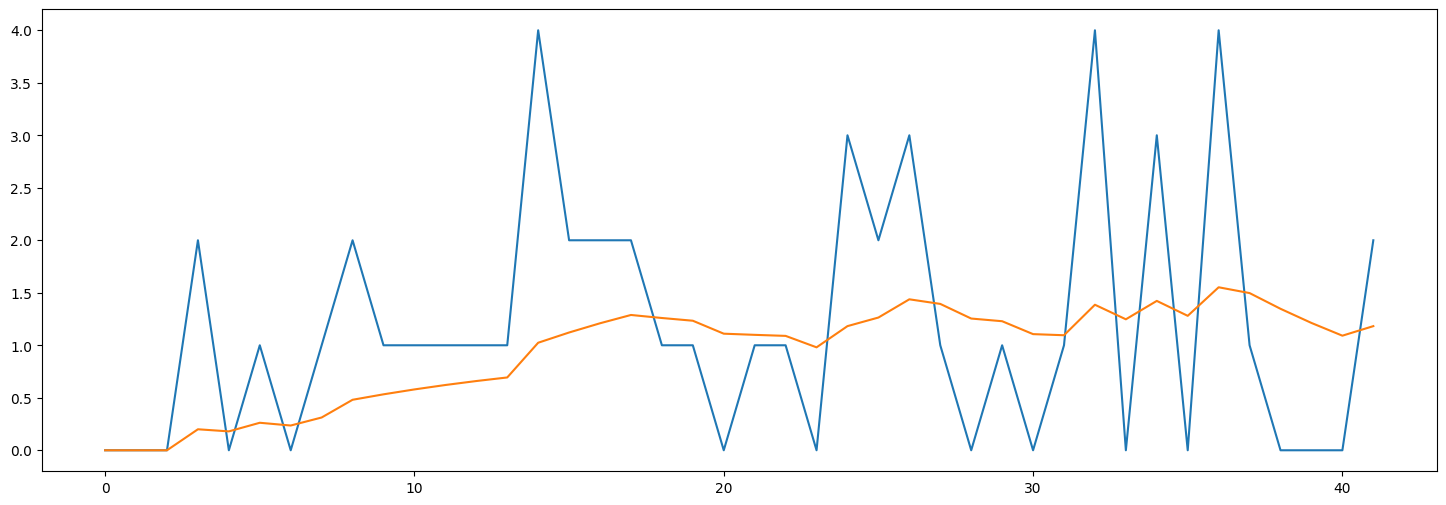

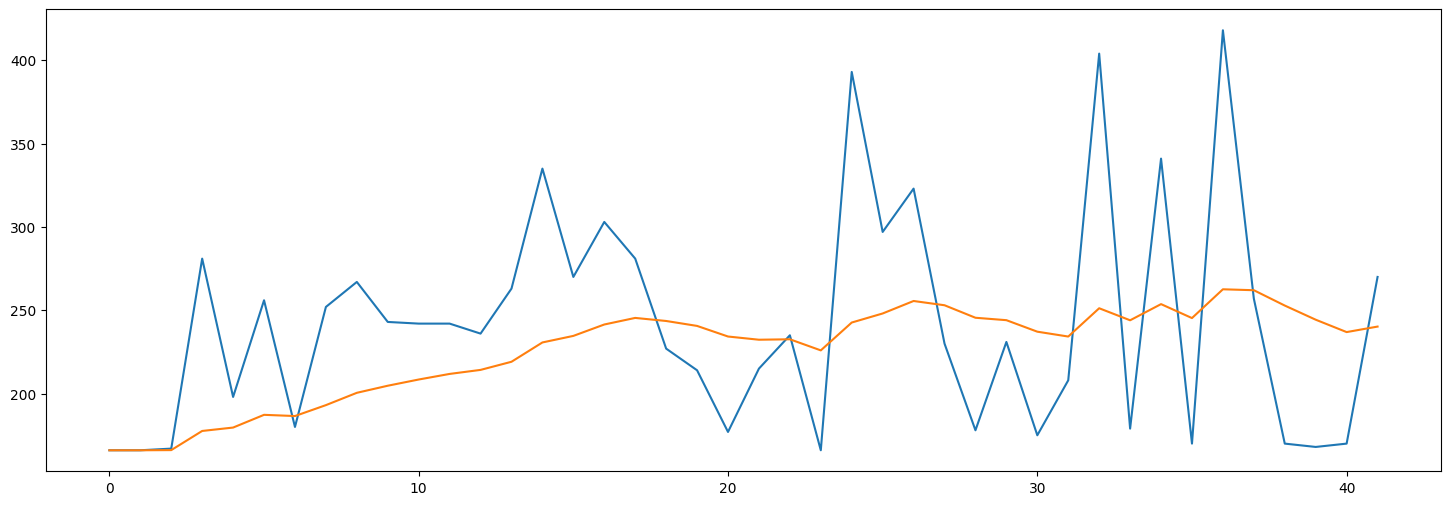

In [7]:
model.show_stat()

In [8]:
i_episode, len(model.scores), model.current_epoch, model.training_time, model.steps_done

(42, 42, 42, 43.79671382904053, 10101)

In [7]:
env.close()